In [1]:
import pandas as pd
import numpy as np

In [2]:
# load data of 39 buildings
df = pd.read_csv('../39个芝加哥办公楼14年6789月.csv')
building_names = df.columns[1:]
load = []
for name in building_names:
    load.append(df[name].values)
load = np.array(load)

# choose one building
data_ori = load[0]

# use max-min normalizaion
maxval = np.max(data_ori)
minval = np.min(data_ori)
data_nor = list(map(lambda x: (x - minval) / (maxval - minval), data_ori))

In [3]:
# parameters:
ifs = 24   # input feature size = 1
hfs = 30  # hidden feature size = 10
pfs =24   # predict feature size = 1
mbs = 1

In [8]:
def multi_pred_navie_dataset(ratio=0.7):
    data_X = []
    data_Y = []
    
    for i in range(len(data_nor)-pfs):
        data_X.append(data_nor[i:i+pfs])
        data_Y.append(data_nor[i+1:i+pfs+1])
    
    train_size = int(len(data_X) * ratio)
    train_r = train_size - (train_size % mbs)
    
    test_size = len(data_X) - train_r
    test_r = test_size - (test_size % mbs) + train_r
        
    train_X = data_X[: train_r]
    train_Y = data_Y[: train_r]
    test_X = data_X[train_r : test_r]
    test_Y = data_Y[train_r : test_r]
    
    return [
        np.array(train_X).astype(np.float32),
        np.array(train_Y).astype(np.float32),
        np.array(test_X).astype(np.float32), 
        np.array(test_Y).astype(np.float32)
    ]

In [9]:
[train_X, train_Y, test_X, test_Y] = multi_pred_navie_dataset(0.2)

In [10]:
import torch
import torch.autograd as autograd
import torch.nn as nn
from torch.autograd import Variable

In [11]:
class lstm(nn.Module):
    def __init__(self, input_size=24, hidden_size=30, output_size=24, num_layer=1):
        super(lstm, self).__init__()
        self.hidden_size = hidden_size
        self.num_layer = num_layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layer)
        self.hidden = self.init_hidden()
        self.hidden2pred = nn.Linear(hidden_size, output_size) 
        
    def init_hidden(self):
        h0 = autograd.Variable(torch.zeros(self.num_layer, mbs, self.hidden_size)).cuda()
        c0 = autograd.Variable(torch.zeros(self.num_layer, mbs, self.hidden_size)).cuda()
        return (h0, c0)
        
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        x, y, z = lstm_out.size()
        output = self.hidden2pred(lstm_out.view(x * y, z))
        return output.view(x, y, -1)

In [12]:
[train_X, train_Y, test_X, test_Y] = multi_pred_navie_dataset(0.2)

In [13]:
import torch
import torch.autograd as autograd
import torch.nn as nn
from torch.autograd import Variable

In [14]:
class lstm(nn.Module):
    def __init__(self, input_size=24, hidden_size=30, output_size=24, num_layer=1):
        super(lstm, self).__init__()
        self.hidden_size = hidden_size
        self.num_layer = num_layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layer)
        self.hidden = self.init_hidden()
        self.hidden2pred = nn.Linear(hidden_size, output_size) 
        
    def init_hidden(self):
        h0 = autograd.Variable(torch.zeros(self.num_layer, mbs, self.hidden_size)).cuda()
        c0 = autograd.Variable(torch.zeros(self.num_layer, mbs, self.hidden_size)).cuda()
        return (h0, c0)
        
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        x, y, z = lstm_out.size()
        output = self.hidden2pred(lstm_out.view(x * y, z))
        return output.view(x, y, -1)

In [15]:
model = lstm().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [17]:
train_x = torch.from_numpy(train_X).view(-1, mbs, ifs).cuda()
train_y = torch.from_numpy(train_Y).view(-1, mbs,pfs).cuda()
test_x = torch.from_numpy(test_X).view(-1, mbs, ifs).cuda()
test_y = torch.from_numpy(test_Y).view(-1, mbs, pfs).cuda()

In [18]:
%%time
for e in range(800):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    
    out = model(var_x)
    loss = criterion(out, var_y)

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if (e + 1) % 50 == 0:
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

Epoch: 50, Loss: 0.01720
Epoch: 100, Loss: 0.00699
Epoch: 150, Loss: 0.00536
Epoch: 200, Loss: 0.00409
Epoch: 250, Loss: 0.00305
Epoch: 300, Loss: 0.00235
Epoch: 350, Loss: 0.00195
Epoch: 400, Loss: 0.00166
Epoch: 450, Loss: 0.00143
Epoch: 500, Loss: 0.00128
Epoch: 550, Loss: 0.00109
Epoch: 600, Loss: 0.00096
Epoch: 650, Loss: 0.00094
Epoch: 700, Loss: 0.00072
Epoch: 750, Loss: 0.00067
Epoch: 800, Loss: 0.00057
Wall time: 41min 3s


In [19]:
import matplotlib.pyplot as plt

In [79]:
model = model.eval()
pred_tensor = model(Variable(test_x))

In [80]:
pred_tensor_p = [pred_tensor[24*i].cpu().detach().numpy() for i in range(69)]

In [81]:
pred_p = np.array(pred_tensor_p).reshape(-1)

In [82]:
test_y = torch.from_numpy(test_Y).view(-1, mbs, pfs).cuda()
test_y_p = [test_y[24*i].cpu().detach().numpy() for i in range(69)]

In [85]:
real_p = np.array(test_y_p).reshape(-1)

In [86]:
diff = []
for i in range(len(real_p)):
    diff.append((real_p[i] - pred_p[i])**2)
print(sum(diff) / len(diff))

0.000506224783106123


In [87]:
real_p

array([0.525, 0.55 , 0.4  , ..., 0.35 , 0.325, 0.325], dtype=float32)

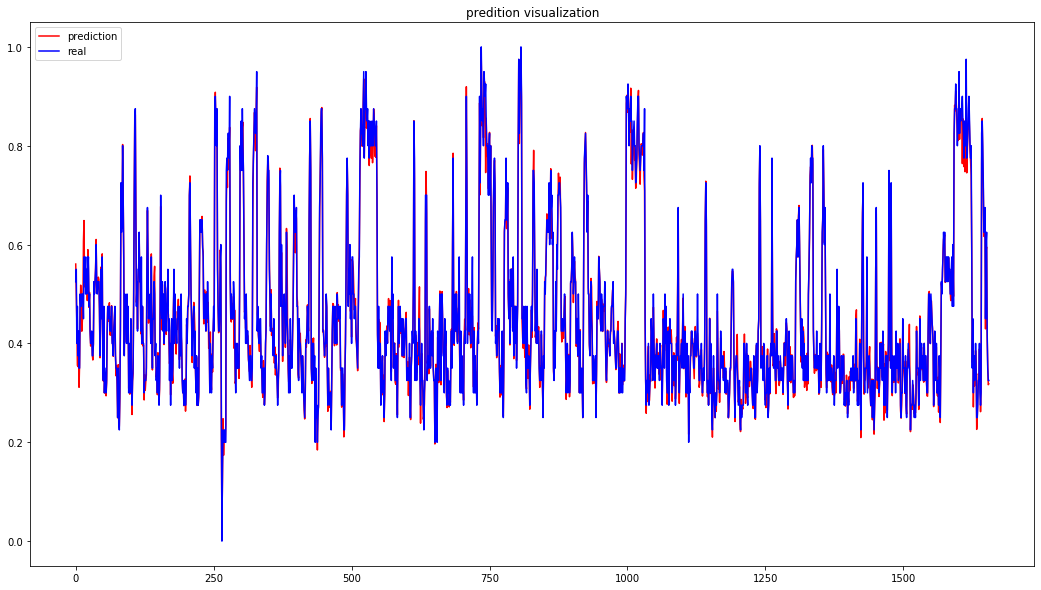

In [90]:
plt.figure(figsize=(18, 10))
plt.title('predition visualization')
plt.plot(pred_p, 'r', label='prediction')
plt.plot(real_p, 'b', label='real')
plt.legend(loc='best')

In [94]:
p = pred_p.reshape(-1, 24)
r = real_p.reshape(-1, 24)

In [95]:
psum, rsum, pmax, rmax, pmin, rmin = [], [], [], [], [], []

for i in range(p.shape[0]):
    psum.append(sum(p[i]))
    rsum.append(sum(r[i]))
    
    pmax.append(max(p[i]))
    rmax.append(max(r[i]))
    
    pmin.append(min(p[i]))
    rmin.append(min(r[i]))

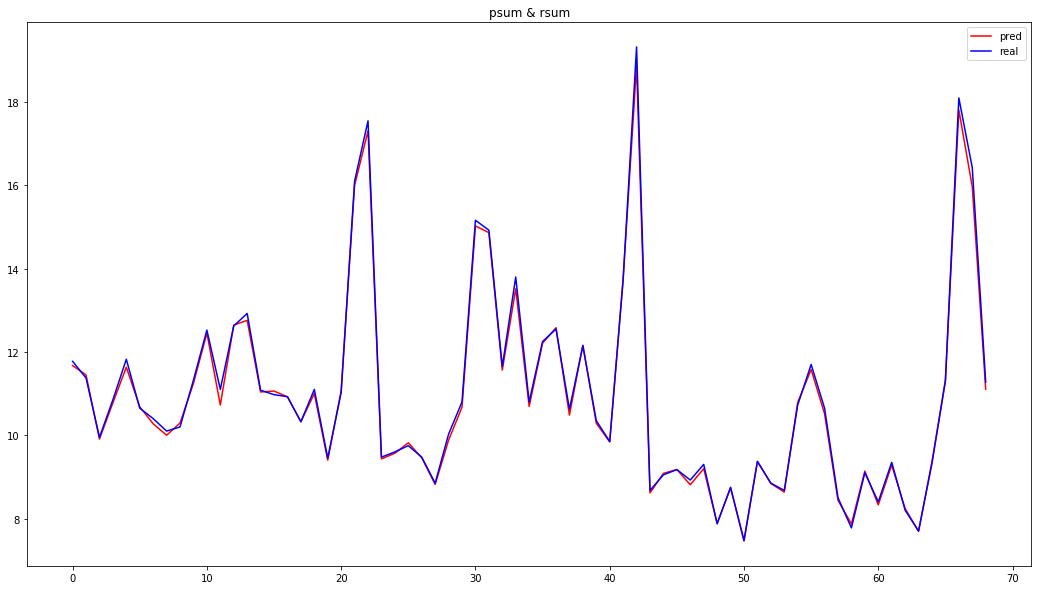

In [96]:
plt.figure(figsize=(18, 10))
plt.title('psum & rsum')
plt.plot(psum, 'r', label='pred')
plt.plot(rsum, 'b', label='real')
plt.legend(loc='best')

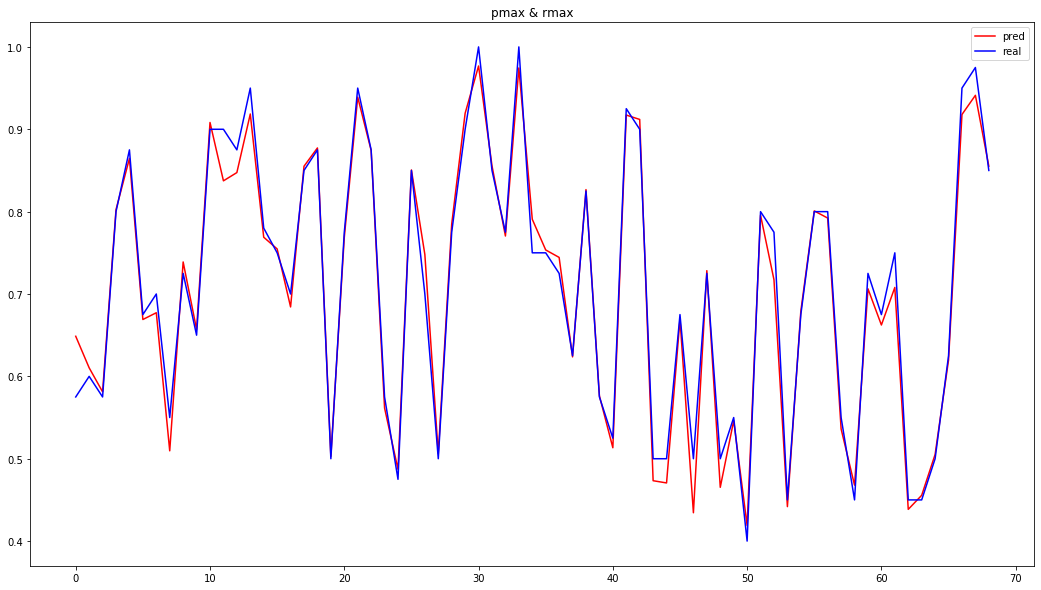

In [97]:
plt.figure(figsize=(18, 10))
plt.title('pmax & rmax')
plt.plot(pmax, 'r', label='pred')
plt.plot(rmax, 'b', label='real')
plt.legend(loc='best')

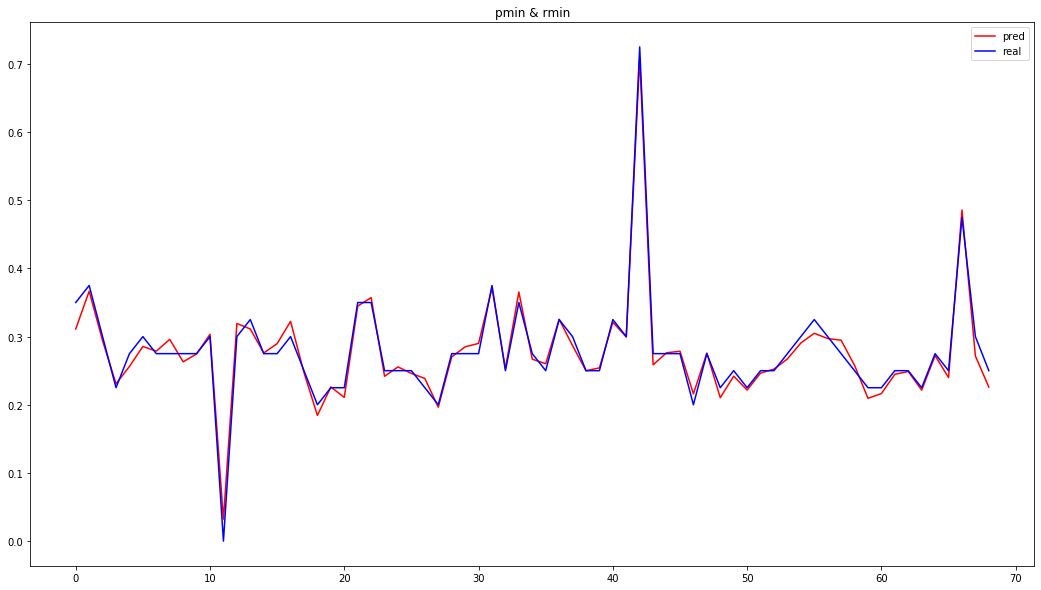

In [98]:
plt.figure(figsize=(18, 10))
plt.title('pmin & rmin')
plt.plot(pmin, 'r', label='pred')
plt.plot(rmin, 'b', label='real')
plt.legend(loc='best')

In [99]:
sumdiff = 0
for i in range(len(psum)):
    sumdiff += (psum[i] - rsum[i]) ** 2
    
sumdiff / len(psum)

0.01712793598994958

In [100]:
maxdiff = 0
for i in range(len(pmax)):
    maxdiff += (pmax[i] - rmax[i]) ** 2
    
maxdiff / len(pmax)

0.0005423259688627048

In [101]:
mindiff = 0
for i in range(len(pmax)):
    mindiff += (pmin[i] - rmin[i]) ** 2
    
mindiff / len(pmin)

0.0001603438478018569